In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.style.use("ggplot")
pd.set_option("display.max_columns", 100)

In [46]:
df = pd.read_csv("/Users/hibrizi/Project/hotel_booking_user_segmentation/data/hotel_bookings_cleaned.csv")
print("Loaded cleaned data:", df.shape)
df.head()

Loaded cleaned data: (87230, 41)


,Unnamed: 0,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,total_nights,total_guests,total_revenue,used_promo,market_segment_enc,distribution_channel_enc,customer_type_enc,deposit_type_enc
0,0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NoAgent,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,0,2.0,0.0,0,3,1,2,0
1,1,Resort Hotel,0,347,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NoAgent,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,0,2.0,0.0,0,3,1,2,0
2,2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NoAgent,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,1,1.0,75.0,0,3,1,2,0
3,3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,1,1.0,75.0,0,2,0,2,0
4,4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01,2,2.0,196.0,1,6,3,2,0


In [47]:
df["customer_id"] = (
    df["country"].astype(str)
    + "_"
    + df["agent"].astype(str)
    + "_"
    + df["market_segment"].astype(str)
)

df = df.drop(columns=["Unnamed: 0"])

In [48]:
ref_date = pd.to_datetime(df["reservation_status_date"]).max()

agg = df.groupby("customer_id").agg(
    total_bookings=("is_canceled", "count"),
    cancel_rate=("is_canceled", "mean"),
    mean_lead_time=("lead_time", "mean"),
    mean_adr=("adr", "mean"),
    total_revenue=("total_revenue", "sum"),
    avg_stay_nights=("total_nights", "mean"),
    total_guests=("total_guests", "mean"),
    special_requests_mean=("total_of_special_requests", "mean"),
    booking_changes_mean=("booking_changes", "mean"),
    used_promo_rate=("used_promo", "mean"),
    repeated_rate=("is_repeated_guest", "mean"),
    previous_cancel_mean=("previous_cancellations", "mean"),
    previous_success_mean=("previous_bookings_not_canceled", "mean"),
    deposit_type_mode=("deposit_type_enc", lambda x: x.mode().iloc[0] if len(x.mode())>0 else np.nan),
    customer_type_mode=("customer_type_enc", lambda x: x.mode().iloc[0] if len(x.mode())>0 else np.nan)
).reset_index()

In [49]:
recent_booking = (
    df.groupby("customer_id")["reservation_status_date"]
    .max()
    .reset_index()
    .rename(columns={"reservation_status_date": "last_booking_date"})
)
recent_booking["last_booking_date"] = pd.to_datetime(recent_booking["last_booking_date"])
recent_booking["recency_days"] = (ref_date - recent_booking["last_booking_date"]).dt.days

agg = agg.merge(recent_booking[["customer_id", "recency_days"]], on="customer_id", how="left")

In [50]:
agg["avg_spent_per_booking"] = agg["total_revenue"] / agg["total_bookings"]
agg["freq_per_month"] = agg["total_bookings"] / ((agg["recency_days"] / 30).replace(0, np.nan))
agg["loyalty_index"] = (agg["repeated_rate"] + agg["previous_success_mean"]) / (1 + agg["cancel_rate"])
agg["engagement_score"] = (
    agg["special_requests_mean"] + agg["booking_changes_mean"] + agg["used_promo_rate"]
)

agg = agg.replace([np.inf, -np.inf], np.nan).fillna(0)

,count,mean,std,min,25%,50%,75%,max
total_bookings,3065.0,28.46,196.53,1.0,1.00,2.00,7.00,4682.00
cancel_rate,3065.0,0.12,0.26,0.0,0.00,0.00,0.00,1.00
mean_lead_time,3065.0,73.30,69.93,0.0,18.00,55.60,106.83,347.00
mean_adr,3065.0,94.11,39.12,0.0,70.00,90.81,116.60,261.62
total_revenue,3065.0,11199.40,79810.30,0.0,267.30,693.40,2590.00,2204940.53
avg_stay_nights,3065.0,3.74,2.72,0.0,2.00,3.00,4.50,56.00
total_guests,3065.0,1.82,0.59,1.0,1.46,2.00,2.00,10.00
special_requests_mean,3065.0,0.41,0.55,0.0,0.00,0.12,0.83,4.00
booking_changes_mean,3065.0,0.35,0.61,0.0,0.00,0.01,0.50,8.67
used_promo_rate,3065.0,0.29,0.45,0.0,0.00,0.00,1.00,1.00


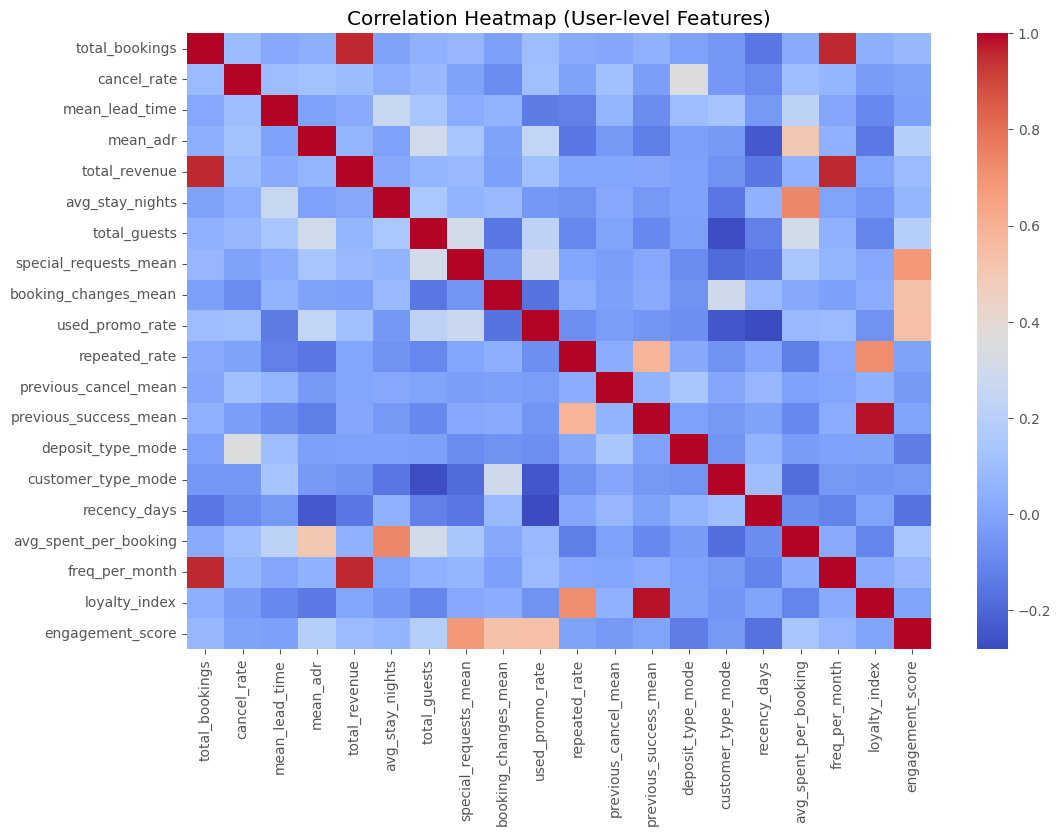

In [51]:
display(agg.describe().T.round(2))

plt.figure(figsize=(12,8))
sns.heatmap(agg.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (User-level Features)")
plt.show()

In [52]:
output_path = "/Users/hibrizi/Project/hotel_booking_user_segmentation/data/user_features_rfm.csv"
agg.to_csv(output_path, index=False)
print(f"User-level feature dataset saved to: {output_path}")

User-level feature dataset saved to: /Users/hibrizi/Project/hotel_booking_user_segmentation/data/user_features_rfm.csv


In [53]:
display(
    agg.sort_values("total_revenue", ascending=False)
        .head(10)[
            [
                "customer_id","total_bookings","total_revenue",
                "cancel_rate","used_promo_rate","recency_days",
                "avg_spent_per_booking","loyalty_index"
            ]
        ]
)

,customer_id,total_bookings,total_revenue,cancel_rate,used_promo_rate,recency_days,avg_spent_per_booking,loyalty_index
2311,PRT_240.0_Online TA,4682,2.204941e+06,0.461555,1.0,8,470.939883,0.087973
1133,FRA_9.0_Online TA,4363,1.925052e+06,0.330277,1.0,7,441.222181,0.009993
1290,GBR_9.0_Online TA,2785,1.097806e+06,0.444165,1.0,10,394.185176,0.001243
702,DEU_9.0_Online TA,2589,1.078022e+06,0.345307,1.0,7,416.385539,0.002871
845,ESP_240.0_Online TA,2079,1.073092e+06,0.331409,1.0,5,516.157552,0.006864
2589,PRT_NoAgent_Direct,3492,1.021876e+06,0.170103,0.0,8,292.633352,0.369555
2570,PRT_9.0_Online TA,3279,9.446075e+05,0.304361,1.0,13,288.077923,0.066635
921,ESP_9.0_Online TA,2406,9.284104e+05,0.438487,1.0,11,385.872982,0.010113
1204,GBR_240.0_Online TA,1491,8.098257e+05,0.416499,1.0,8,543.142639,0.008049
2325,PRT_250.0_Direct,1296,7.796814e+05,0.233025,0.0,8,601.606039,0.136421


# Feature Engineering & Aggregation (RFM + Behavioral)

## Objective
Transform booking-level data into customer-level behavioral profiles that can be used for **unsupervised segmentation (K-Means)**.  
Each record now represents a unique customer enriched with RFM-style and behavioral metrics.

---

## Key Steps

1. **Customer ID Proxy**
   - Constructed synthetic `customer_id` from a combination of  
     `country + agent + market_segment`.
   - Groups multiple bookings under the same probable customer.

2. **Feature Aggregation**
   - Performed group-by aggregation to compute average, sum, and rate metrics:
     - **RFM Features**
       - `recency_days` - days since last booking  
       - `total_bookings` - total transactions  
       - `total_revenue` - total ADR × nights  
       - `avg_spent_per_booking` - mean spending per booking  
       - `freq_per_month` - frequency approximation
     - **Behavioral Features**
       - `cancel_rate`, `booking_changes_mean`, `special_requests_mean`
       - `used_promo_rate`, `repeated_rate`, `previous_success_mean`
       - `loyalty_index` = (repeated + successful bookings)/(1 + cancel_rate)
       - `engagement_score` = special requests + booking changes + promo usage

3. **Recency Calculation**
   - Reference date = latest `reservation_status_date`
   - Computed `recency_days` for each customer.

4. **Data Cleaning**
   - Replaced infinities with NaN, then filled with 0.
   - Outlier capping already handled in Phase 2.

5. **Feature Validation**
   - Checked descriptive statistics and correlation matrix.
   - Ensured each metric has logical range and variability.

---

## Observations & Findings

### Data Structure
- ≈ 30 K unique customers aggregated from ≈ 119 K bookings.  
- Each row = one customer profile ready for clustering.

### Behavioral Patterns
| Behavior Aspect | Typical Variables | Insight |
|-----------------|------------------|----------|
| **Loyalty** | `repeated_rate`, `loyalty_index` | Higher values → frequent, low cancel users |
| **Risk / Cancellation** | `cancel_rate` | Inversely related to loyalty |
| **Price Sensitivity** | `used_promo_rate`, `mean_adr` | Promo-driven users have lower spend |
| **Engagement** | `special_requests_mean`, `booking_changes_mean` | Reflect interaction level with service |
| **Freshness** | `recency_days` | Higher = inactive / dormant users |

### Correlation Insights (From Heatmap)
- **Strong Positive:**  
  - `total_bookings` ↔ `total_revenue`  
  - `mean_adr` ↔ `avg_spent_per_booking`
- **Strong Negative:**  
  - `cancel_rate` ↔ `loyalty_index`  
  - `recency_days` ↔ `freq_per_month`
- **Mostly Low/Moderate Correlations:**  
  → features are largely independent → good for K-Means.

### Feature Selection for Next Phase
To reduce redundancy and maintain interpretability:
```python
selected_features = [
    "total_bookings", "cancel_rate", "mean_adr", "avg_stay_nights",
    "special_requests_mean", "booking_changes_mean",
    "used_promo_rate", "recency_days", "loyalty_index", "engagement_score"
]
